# Neural Network Compression with the Tensor-Train Decomposition in ``TensorLy`` and ``PyTorch``

In this notebook, we will show how to use **TensorLy** [1] to store the weights of a deep neural network (DNN) in the TT-Matrix format [2].

As a toy example, we show how one can use a vastly smaller number of parameters to store the weights of a network to classify digits in the MNIST dataset, whilst sacrificing only a 2% drop in classification over its counterpart in non TT-matrix format.

Included is the following:

1. [Storing an FC layer's weights in the TT-matrix format](#Storing-an-FC-layer's-weights-in-the-TT-matrix-format)
2. [Defining the networks](#Define-the-networks)
3. [Model comparison (number of parameters vs accuracy)](#Model-comparison)

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import numpy as np

import tensorly as tl

Import TensorLy and set the backend to PyTorch:

In [3]:
import tensorly as tl
tl.set_backend('pytorch')

Parameters of the experiment:

In [4]:
batch_size = 16
device = 'cpu'

Let us load the MNIST dataset. The following code will automatically download the data in a `data` folder if it hasn't already been done.

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

## Storing an FC layer's weights in the TT-matrix format

One option is to apply the TT-decomposition directly on the weight matrices $\mathbf{W}$. This simply corresponds to the standard matrix decomposition however, and thus doesn't fully exploit the parameter-saving capabilities of the TT-decomposition.

Given the weights $\mathbf{W}$ of a fully-connected layer, one can instead represent $\mathcal{W}$ in the TT-matrix format--greatly reducing the number of parameters we have to store, with us only needing to store the 4-th order TT-matrix cores. This format also opens up the option of computing efficient forward-passes if the input vectors $\mathbf{x}$ are also represented in this format.

In [6]:
class TTLayer(nn.Module):
    """
    Stores the weights of a fully connected layer in the TT-matrix format
    """
    def __init__(self, shape, rank=2, **kwargs):
        super(TTLayer, self).__init__(**kwargs)
        
        self.rank = rank
        self.shape = shape
        
        # Add and register the factors
        self.factors = nn.ParameterList(
            [nn.Parameter(f, requires_grad=True) for f in tl.random.random_tt_matrix(shape, rank=rank)]
        )
        
        # initialise weights
        for f in self.factors:
            f.data.uniform_(-0.1, 0.1)
            
    def forward(self, x):
        # form full weight matrix
        W = tl.tt_matrix.tt_matrix_to_matrix(self.factors)
        
        # perform regular matrix multiplication
        return torch.matmul(x, W)
    
    def get_num_params(self):
        return sum([p.numel() for p in self.parameters()])

# Define the networks

We'll define a very simple fully-connected network with two layers, following the experiments section in [2]. The network is thus composed of two weight matrices: $\mathbf{W}^{(1)}\in\mathbb{R}^{1024\times1024}$ and $\mathbf{W}^{(2)}\in\mathbb{R}^{10\times1024}$.

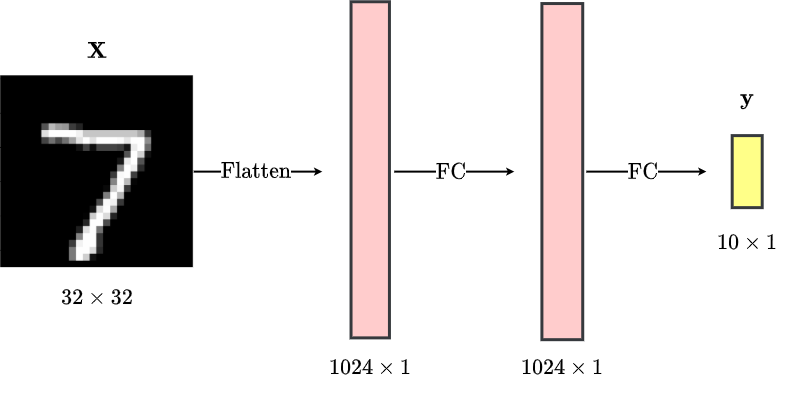

In [7]:
from IPython.display import Image, display
display(Image(filename='./images/fc-tt.png', embed=True))

We'll store these weights explicitly in the first model, and then we'll also store them in the TT-matrix format in the second two models, and see how the networks perform.

In [8]:
class Net(nn.Module):
    def __init__(self, use_tt=False, rank=32):
        super(Net, self).__init__()
        
        self.fc1 = TTLayer([32, 32, 32, 32], rank=rank) if use_tt else nn.Linear(1024, 1024)
        self.fc2 = TTLayer([32, 32, 2, 5], rank=rank) if use_tt else nn.Linear(1024, 10)
        
    def get_num_params(self):
        return sum([p.numel() for p in self.parameters() if p.requires_grad])

    def forward(self, x):
        x = torch.nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
    
ranks = [16, 8, 4, 2]
models = [Net(use_tt=False)] + [Net(use_tt=True, rank=r) for r in ranks]

Finally, the training loop.

In [9]:
import time

n_epoch = 5 # Number of epochs

models_acc = []
for i, model in enumerate(models):
    model = model.to(device)
    print('Training network {}...'.format(i))
    start = time.process_time()

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion=nn.CrossEntropyLoss()

    def train(n_epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Important: do not forget to reset the gradients
            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()

    def test():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output,target)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        
        return 100. * correct / len(test_loader.dataset)

    for epoch in range(1, n_epoch):
        train(epoch)
        acc = test()
        
    print('Test set acc: {}%\tTime taken: {}'.format(acc, time.process_time() - start))
    models_acc += [acc]

Training network 0...
Test set acc: 98.18000030517578%	Time taken: 332.023754811
Training network 1...
Test set acc: 96.4000015258789%	Time taken: 326.902922782
Training network 2...
Test set acc: 96.19999694824219%	Time taken: 324.1698835149999
Training network 3...
Test set acc: 96.36000061035156%	Time taken: 304.891494923
Training network 4...
Test set acc: 95.12000274658203%	Time taken: 301.8954625690001


## Model comparison

Plotted below is the models' number of parameters and their respective test-set accuracies after 5 epochs of training.

As we can see, storing the weights in the TT-format allows us to store the model with very few paramters! As a next step, one can store the input vector itself in the tt-matrix format for faster forward passes--without needing to materialise the whole matrix from its TT-matrix representation everytime.

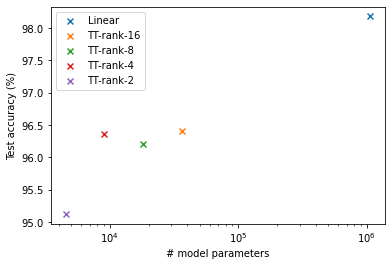

In [10]:
from matplotlib import pyplot as plt

xs = ['Linear'] + ['TT-rank-{}'.format(rank) for rank in ranks]
for i, x in enumerate(xs):
    plt.scatter(models[i].get_num_params(), models_acc[i], label=x, marker='x')
    plt.legend()

plt.xscale('log')
plt.xlabel('# model parameters')
plt.ylabel('Test accuracy (%)')
plt.show()

# References

---

[1]: Jean Kossaifi, Yannis Panagakis, Anima Anandkumar and Maja Pantic, TensorLy: Tensor Learning in Python, https://arxiv.org/abs/1610.09555.

[2]: A. Novikov, D. Podoprikhin, A. Osokin, and D. Vetrov, ‘Tensorizing Neural Networks’, arXiv:1509.06569 [cs], Dec. 2015, Accessed: Jul. 27, 2020. [Online]. Available: http://arxiv.org/abs/1509.06569.